In [ ]:
import tensorflow as tf
import os
import random
import numpy as np
from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt
from sklearn import metrics
import skimage.color
import pickle
import time
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from yellowbrick.classifier import ROCAUC

In [ ]:
!pip show tensorflow

Name: tensorflow
Version: 2.15.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, libclang, ml-dtypes, numpy, opt-einsum, packaging, protobuf, setuptools, six, tensorboard, tensorflow-estimator, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: dopamine_rl, tf_keras


In [ ]:
def perf_measure(y_actual, y_pred):
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(y_pred)):
        if y_actual[i] == y_pred[i] == 1:
            TP += 1
        if y_pred[i] == 1 and y_actual[i] != y_pred[i]:
            FP += 1
        if y_actual[i] == y_pred[i] == 0:
            TN += 1
        if y_pred[i] == 0 and y_actual[i] != y_pred[i]:
            FN += 1

    return TP, FP, TN, FN

In [ ]:
start_time = time.time()

In [ ]:
seed = 42
np.random.seed = seed

IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
CT_PATH = '/content/drive/MyDrive/Bitirme_Projesi/dataset/CT_10K/'
MASK_PATH = '/content/drive/MyDrive/Bitirme_Projesi/dataset/mask_10K/'


images = os.listdir(CT_PATH)

In [ ]:
X = np.zeros((len(images), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y = np.zeros((len(images), IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)

In [ ]:
print('Resizing training images and masks')

for i in range(len(images)):
    img = imread(CT_PATH + images[i])
    img = skimage.color.gray2rgb(img)[:, :, :IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X[i] = img  # Fill empty X_train with values from img

    mask = imread(MASK_PATH + images[i])
    mask = np.expand_dims(resize(mask, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True), axis=-1)
    Y[i] = mask

    print(i)

Görüntülenen çıkış son 5000 satıra kısaltıldı.
5002
5003
5004
5005
5006
5007
5008
5009
5010
5011
5012
5013
5014
5015
5016
5017
5018
5019
5020
5021
5022
5023
5024
5025
5026
5027
5028
5029
5030
5031
5032
5033
5034
5035
5036
5037
5038
5039
5040
5041
5042
5043
5044
5045
5046
5047
5048
5049
5050
5051
5052
5053
5054
5055
5056
5057
5058
5059
5060
5061
5062
5063
5064
5065
5066
5067
5068
5069
5070
5071
5072
5073
5074
5075
5076
5077
5078
5079
5080
5081
5082
5083
5084
5085
5086
5087
5088
5089
5090
5091
5092
5093
5094
5095
5096
5097
5098
5099
5100
5101
5102
5103
5104
5105
5106
5107
5108
5109
5110
5111
5112
5113
5114
5115
5116
5117
5118
5119
5120
5121
5122
5123
5124
5125
5126
5127
5128
5129
5130
5131
5132
5133
5134
5135
5136
5137
5138
5139
5140
5141
5142
5143
5144
5145
5146
5147
5148
5149
5150
5151
5152
5153
5154
5155
5156
5157
5158
5159
5160
5161
5162
5163
5164
5165
5166
5167
5168
5169
5170
5171
5172
5173
5174
5175
5176
5177
5178
5179
5180
5181
5182
5183
5184
5185
5186
5187
5188
5189
5190
5191
519

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
image_x = random.randint(0, len(images))
print(len(Y))

10002


In [ ]:
def contains_file(files_array, target_file):
    for file_name in files_array:
        if file_name == target_file:
            return True
    return False

In [ ]:
target_file = '111-slice_43.png'
mask_dir = '/content/drive/MyDrive/Bitirme_Projesi/dataset/mask_10K/'
CT_dir = '/content/drive/MyDrive/Bitirme_Projesi/dataset/CT_10K/'
# List all files in the directory
files_array = os.listdir(CT_dir)
if contains_file(files_array, target_file):
    print("The array contains the file:", target_file)
else:
    print("The array does not contain the file:", target_file)

The array contains the file: 111-slice_43.png


In [ ]:
def find_missing_mask_files(ct_folder, mask_folder):
    ct_files = os.listdir(ct_folder)
    mask_files = os.listdir(mask_folder)

    ct_files_base = [os.path.splitext(f)[0] for f in ct_files]
    mask_files_base = [os.path.splitext(f)[0].replace('_mask', '') for f in mask_files]

    missing_files = [f for f in ct_files_base if f not in mask_files_base]

    return missing_files

def find_extra_mask_files(ct_folder, mask_folder):
    ct_files = os.listdir(ct_folder)
    mask_files = os.listdir(mask_folder)

    ct_files_base = [os.path.splitext(f)[0] for f in ct_files]
    mask_files_base = [os.path.splitext(f)[0].replace('_mask', '') for f in mask_files]

    extra_mask_files = [f for f in mask_files_base if f not in ct_files_base]

    return extra_mask_files

missing_files_in_ct = find_missing_mask_files(CT_dir, mask_dir)
extra_files_in_mask = find_extra_mask_files(CT_dir, mask_dir)

if missing_files_in_ct:
    print("Files in train_CT folder without corresponding files in train_mask folder:")
    for file in missing_files_in_ct:
        print(file + ".png")
else:
    print("All files in train_CT have corresponding files in train_mask.")

if extra_files_in_mask:
    print("Files in train_mask folder without corresponding files in train_CT folder:")
    for file in extra_files_in_mask:
        print(file + "_mask.png")
else:
    print("All files in train_mask have corresponding files in train_CT.")

All files in train_CT have corresponding files in train_mask.
All files in train_mask have corresponding files in train_CT.


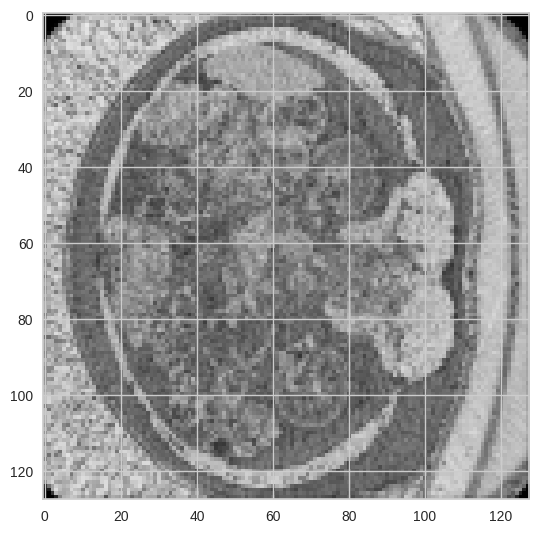

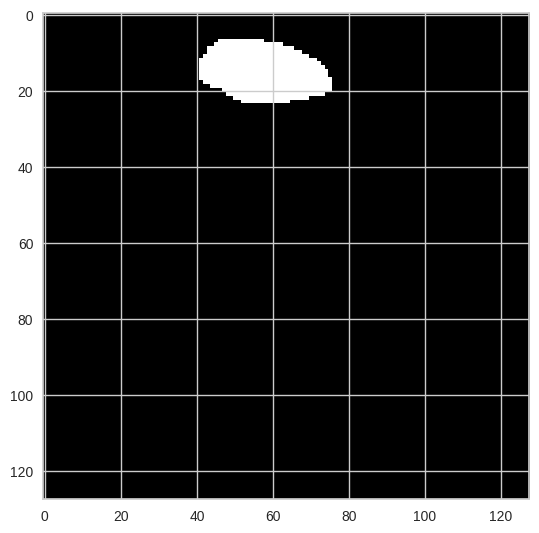

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=123)

image_x = random.randint(0, len(images))
imshow(X_train[image_x])
plt.show()
imshow(np.squeeze(Y_train[image_x]))
plt.show()

In [ ]:
# Build the model
inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

In [ ]:
from keras import backend as K
from keras.layers import Layer


class MaxPoolingWithArgmax2D(Layer):

    def __init__(
            self,
            pool_size=(2, 2),
            strides=(2, 2),
            padding='same',
            **kwargs):
        super(MaxPoolingWithArgmax2D, self).__init__(**kwargs)
        self.padding = padding
        self.pool_size = pool_size
        self.strides = strides

    def call(self, inputs, **kwargs):
        print("max pooling with argmax")
        padding = self.padding
        pool_size = self.pool_size
        strides = self.strides
        if K.backend() == 'tensorflow':
            ksize = [1, pool_size[0], pool_size[1], 1]
            padding = padding.upper()
            strides = [1, strides[0], strides[1], 1]
            output, argmax = tf.nn.max_pool_with_argmax(
                    inputs,
                    ksize=ksize,
                    strides=strides,
                    padding=padding)
        else:
            errmsg = '{} backend is not supported for layer {}'.format(
                    K.backend(), type(self).__name__)
            raise NotImplementedError(errmsg)
        argmax = K.cast(argmax, K.floatx())
        return [output, argmax]

    def compute_output_shape(self, input_shape):
        print("i guess its subsampling")
        ratio = (1, 2, 2, 1)
        output_shape = [
                dim//ratio[idx]
                if dim is not None else None
                for idx, dim in enumerate(input_shape)]
        output_shape = tuple(output_shape)
        return [output_shape, output_shape]


    def compute_mask(self, inputs, mask=None):
        print("no idea what this is: but computing mask")
        return 2 * [None]


class MaxUnpooling2D(Layer):
    def __init__(self, size=(2, 2), **kwargs):
        super(MaxUnpooling2D, self).__init__(**kwargs)
        self.size = size

    def call(self, inputs, output_shape=None):
        # one is pool and one is mask
        updates, mask = inputs[0], inputs[1]

        with tf.compat.v1.variable_scope(self.name):
            mask = K.cast(mask, 'int32')
            input_shape = tf.shape(updates, out_type='int32')     # it gives a dynamic shape of a given tensor.

            #  calculation new shape
            if output_shape is None:
                output_shape = (
                        input_shape[0],
                        input_shape[1]*self.size[0],
                        input_shape[2]*self.size[1],
                        input_shape[3])
            self.output_shape1 = output_shape

            # calculation indices for batch, height, width and feature maps
            one_like_mask = K.ones_like(mask, dtype='int32')      #creates ones of the same shape as the mask
            batch_shape = K.concatenate([[input_shape[0]], [1], [1], [1]], axis=0)
            batch_range = K.reshape(tf.range(output_shape[0], dtype='int32'),shape=batch_shape)
            b = one_like_mask * batch_range

            y = mask // (output_shape[2] * output_shape[3])

            x = (mask // output_shape[3]) % output_shape[2]

            feature_range = tf.range(output_shape[3], dtype='int32')

            f = one_like_mask * feature_range

            # transpose indices & reshape update values to one dimension
            updates_size = tf.size(updates)       # Prints the number of elements in the updates
            indices = K.transpose(K.reshape(K.stack([b, y, x, f]), [4, updates_size]))
            values = K.reshape(updates, [updates_size])
            ret = tf.scatter_nd(indices, values, output_shape)
            return ret

    def compute_output_shape(self, input_shape):
        mask_shape = input_shape[1]
        return (
                mask_shape[0],
                mask_shape[1]*self.size[0],
                mask_shape[2]*self.size[1],
                mask_shape[3]
                )

In [ ]:
!pip show Keras

Name: keras
Version: 2.15.0
Summary: Deep learning for humans.
Home-page: https://keras.io/
Author: Keras team
Author-email: keras-users@googlegroups.com
License: Apache 2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: 
Required-by: tensorflow


In [ ]:
from keras.models import Model
from keras.layers import Input
from keras.layers import Activation, Reshape, Dense
from keras.layers import Convolution2D
from keras.layers import BatchNormalization

#from layers import MaxPoolingWithArgmax2D, MaxUnpooling2D

def segnet(
        input_shape,
        n_labels,
        kernel=3,
        pool_size=(2, 2),
        output_mode="softmax"):
    # encoder
    inputs = Input(shape=input_shape)

    conv_1 = Convolution2D(64, (kernel, kernel), padding="same", kernel_initializer='he_normal', name="block1_conv1")(inputs)
    conv_1 = BatchNormalization()(conv_1)
    conv_1 = Activation("relu")(conv_1)
    conv_2 = Convolution2D(64, (kernel, kernel), padding="same", kernel_initializer='he_normal', name="block1_conv2")(conv_1)
    conv_2 = BatchNormalization()(conv_2)
    conv_2 = Activation("relu")(conv_2)
    pool_1, mask_1 = MaxPoolingWithArgmax2D(pool_size, name="block1_pool")(conv_2)

    conv_3 = Convolution2D(128, (kernel, kernel), padding="same" , kernel_initializer='he_normal', name="block2_conv1")(pool_1)
    conv_3 = BatchNormalization()(conv_3)
    conv_3 = Activation("relu")(conv_3)
    conv_4 = Convolution2D(128, (kernel, kernel), padding="same", kernel_initializer='he_normal',  name="block2_conv2")(conv_3)
    conv_4 = BatchNormalization()(conv_4)
    conv_4 = Activation("relu")(conv_4)

    pool_2, mask_2 = MaxPoolingWithArgmax2D(pool_size, name="block2_pool")(conv_4)

    conv_5 = Convolution2D(256, (kernel, kernel), padding="same" , kernel_initializer='he_normal', name="block3_conv1")(pool_2)
    conv_5 = BatchNormalization()(conv_5)
    conv_5 = Activation("relu")(conv_5)
    conv_6 = Convolution2D(256, (kernel, kernel), padding="same" , kernel_initializer='he_normal', name="block3_conv2")(conv_5)
    conv_6 = BatchNormalization()(conv_6)
    conv_6 = Activation("relu")(conv_6)
    conv_7 = Convolution2D(256, (kernel, kernel), padding="same" , kernel_initializer='he_normal', name="block3_conv3")(conv_6)
    conv_7 = BatchNormalization()(conv_7)
    conv_7 = Activation("relu")(conv_7)

    pool_3, mask_3 = MaxPoolingWithArgmax2D(pool_size, name="block3_pool")(conv_7)

    conv_8 = Convolution2D(512, (kernel, kernel), padding="same", kernel_initializer='he_normal', name="block4_conv1")(pool_3)
    conv_8 = BatchNormalization()(conv_8)
    conv_8 = Activation("relu")(conv_8)
    conv_9 = Convolution2D(512, (kernel, kernel), padding="same" , kernel_initializer='he_normal', name="block4_conv2")(conv_8)
    conv_9 = BatchNormalization()(conv_9)
    conv_9 = Activation("relu")(conv_9)
    conv_10 = Convolution2D(512, (kernel, kernel), padding="same" , kernel_initializer='he_normal', name="block4_conv3")(conv_9)
    conv_10 = BatchNormalization()(conv_10)
    conv_10 = Activation("relu")(conv_10)

    pool_4, mask_4 = MaxPoolingWithArgmax2D(pool_size, name="block4_pool")(conv_10)

    conv_11 = Convolution2D(512, (kernel, kernel), padding="same", kernel_initializer='he_normal', name="block5_conv1")(pool_4)
    conv_11 = BatchNormalization()(conv_11)
    conv_11 = Activation("relu")(conv_11)
    conv_12 = Convolution2D(512, (kernel, kernel), padding="same" , kernel_initializer='he_normal',  name="block5_conv2")(conv_11)
    conv_12 = BatchNormalization()(conv_12)
    conv_12 = Activation("relu")(conv_12)
    conv_13 = Convolution2D(512, (kernel, kernel), padding="same" , kernel_initializer='he_normal',  name="block5_conv3")(conv_12)
    conv_13 = BatchNormalization()(conv_13)
    conv_13 = Activation("relu")(conv_13)

    pool_5, mask_5 = MaxPoolingWithArgmax2D(pool_size, name="block5_pool")(conv_13)

    # decoder
    unpool_1 = MaxUnpooling2D(pool_size)([pool_5, mask_5])

    conv_14 = Convolution2D(512, (kernel, kernel), padding="same", kernel_initializer='he_normal')(unpool_1)
    conv_14 = BatchNormalization()(conv_14)
    conv_14 = Activation("relu")(conv_14)
    conv_15 = Convolution2D(512, (kernel, kernel), padding="same", kernel_initializer='he_normal')(conv_14)
    conv_15 = BatchNormalization()(conv_15)
    conv_15 = Activation("relu")(conv_15)
    conv_16 = Convolution2D(512, (kernel, kernel), padding="same", kernel_initializer='he_normal')(conv_15)
    conv_16 = BatchNormalization()(conv_16)
    conv_16 = Activation("relu")(conv_16)

    unpool_2 = MaxUnpooling2D(pool_size)([conv_16, mask_4])

    conv_17 = Convolution2D(512, (kernel, kernel), padding="same", kernel_initializer='he_normal')(unpool_2)
    conv_17 = BatchNormalization()(conv_17)
    conv_17 = Activation("relu")(conv_17)
    conv_18 = Convolution2D(512, (kernel, kernel), padding="same", kernel_initializer='he_normal')(conv_17)
    conv_18 = BatchNormalization()(conv_18)
    conv_18 = Activation("relu")(conv_18)
    conv_19 = Convolution2D(256, (kernel, kernel), padding="same", kernel_initializer='he_normal')(conv_18)
    conv_19 = BatchNormalization()(conv_19)
    conv_19 = Activation("relu")(conv_19)

    unpool_3 = MaxUnpooling2D(pool_size)([conv_19, mask_3])

    conv_20 = Convolution2D(256, (kernel, kernel), padding="same", kernel_initializer='he_normal')(unpool_3)
    conv_20 = BatchNormalization()(conv_20)
    conv_20 = Activation("relu")(conv_20)
    conv_21 = Convolution2D(256, (kernel, kernel), padding="same", kernel_initializer='he_normal')(conv_20)
    conv_21 = BatchNormalization()(conv_21)
    conv_21 = Activation("relu")(conv_21)
    conv_22 = Convolution2D(128, (kernel, kernel), padding="same", kernel_initializer='he_normal')(conv_21)
    conv_22 = BatchNormalization()(conv_22)
    conv_22 = Activation("relu")(conv_22)

    unpool_4 = MaxUnpooling2D(pool_size)([conv_22, mask_2])

    conv_23 = Convolution2D(128, (kernel, kernel), padding="same", kernel_initializer='he_normal')(unpool_4)
    conv_23 = BatchNormalization()(conv_23)
    conv_23 = Activation("relu")(conv_23)
    conv_24 = Convolution2D(64, (kernel, kernel), padding="same", kernel_initializer='he_normal')(conv_23)
    conv_24 = BatchNormalization()(conv_24)
    conv_24 = Activation("relu")(conv_24)

    unpool_5 = MaxUnpooling2D(pool_size)([conv_24, mask_1])

    conv_25 = Convolution2D(64, (kernel, kernel), padding="same", kernel_initializer='he_normal')(unpool_5)
    conv_25 = BatchNormalization()(conv_25)
    conv_25 = Activation("relu")(conv_25)

    conv_26 = Convolution2D(n_labels, (1, 1), padding="same", kernel_initializer='he_normal')(conv_25)
    conv_26 = BatchNormalization()(conv_26)

    conv_26 = Dense(1)(conv_26)
    outputs = Activation(output_mode)(conv_26)
    print("Build decoder done..")

    model = Model(inputs=inputs, outputs=outputs, name="SegNet")

    return model

In [ ]:
num_classes = 1
input_shape = X_train.shape[1:] #(480,480,3)
smooth = 1.
nproc = 8

In [ ]:
print(len(X_train))

8001


In [ ]:
model= segnet(input_shape=input_shape, n_labels=1, output_mode='sigmoid')  #, single_model

max pooling with argmax
no idea what this is: but computing mask
max pooling with argmax
no idea what this is: but computing mask
max pooling with argmax
no idea what this is: but computing mask
max pooling with argmax
no idea what this is: but computing mask
max pooling with argmax
no idea what this is: but computing mask
Build decoder done..


In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy',
                                                                     tf.keras.metrics.Precision(),
                                                                     tf.keras.metrics.Recall()])
model.summary()

Model: "SegNet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 128, 128, 64)         1792      ['input_2[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 128, 128, 64)         256       ['block1_conv1[0][0]']        
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 128, 128, 64)         0         ['batch_normalization[0][

In [ ]:
VGG16_MODEL=tf.keras.applications.VGG16(include_top=False, weights='imagenet')

58889256/58889256 [==============================] - 4s 0us/step


In [ ]:
VGG16_MODEL.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [ ]:
from tensorflow.keras.layers import Conv2D
layers = model.layers
merged_layers = []
count = 1
for _layer in layers:
  if isinstance(_layer, Convolution2D):
    merged_layers.append(_layer)
  if _layer.name == "block5_pool":
    break

vgg_layer =[]
vgg_layers = VGG16_MODEL.layers
for _layer in vgg_layers:
  if isinstance(_layer, Conv2D):
    vgg_layer.append(_layer)

for seg_model, vgg_model in zip(merged_layers, vgg_layer):
  wk0 = vgg_model.get_weights()
  seg_model.set_weights(wk0)

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy',
                                                                     tf.keras.metrics.Precision(),
                                                                     tf.keras.metrics.Recall()])

In [ ]:
preds = model.predict(X_train[:int(X_train.shape[0] * 0.9)], verbose=1)

max pooling with argmax
no idea what this is: but computing mask
max pooling with argmax
no idea what this is: but computing mask
max pooling with argmax
no idea what this is: but computing mask
max pooling with argmax
no idea what this is: but computing mask
max pooling with argmax
no idea what this is: but computing mask
162/162 [==============================] - 24s 121ms/step


In [ ]:
# Her piksel için en yüksek olasılığa sahip sınıfı bulma
predicted_labels = np.argmax(preds, axis=-1)  # Şekli (5184, 128, 128)

print(preds.shape)  # (5184, 128, 128)

(5184, 128, 128, 1)


In [ ]:
################################
# Modelcheckpoint
checkpointer = tf.keras.callbacks.ModelCheckpoint('model_for_nuclei.keras', verbose=1, save_best_only=True)

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True),
    tf.keras.callbacks.TensorBoard(log_dir='logs')]

results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=25, callbacks=callbacks)

Epoch 1/25
max pooling with argmax
no idea what this is: but computing mask
max pooling with argmax
no idea what this is: but computing mask
max pooling with argmax
no idea what this is: but computing mask
max pooling with argmax
no idea what this is: but computing mask
max pooling with argmax
no idea what this is: but computing mask
max pooling with argmax
no idea what this is: but computing mask
max pooling with argmax
no idea what this is: but computing mask
max pooling with argmax
no idea what this is: but computing mask
max pooling with argmax
no idea what this is: but computing mask
max pooling with argmax
no idea what this is: but computing mask
450/450 [==============================] - ETA: 0s - loss: 0.4959 - accuracy: 0.9803 - precision_1: 0.5855 - recall_1: 0.9478max pooling with argmax
no idea what this is: but computing mask
max pooling with argmax
no idea what this is: but computing mask
max pooling with argmax
no idea what this is: but computing mask
max pooling with ar

In [ ]:
idx = random.randint(0, len(X_train))

preds_train = model.predict(X_train[:int(X_train.shape[0] * 0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0] * 0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

max pooling with argmax
no idea what this is: but computing mask
max pooling with argmax
no idea what this is: but computing mask
max pooling with argmax
no idea what this is: but computing mask
max pooling with argmax
no idea what this is: but computing mask
max pooling with argmax
no idea what this is: but computing mask
225/225 [==============================] - 35s 121ms/step
max pooling with argmax
no idea what this is: but computing mask
max pooling with argmax
no idea what this is: but computing mask
max pooling with argmax
no idea what this is: but computing mask
max pooling with argmax
no idea what this is: but computing mask
max pooling with argmax
no idea what this is: but computing mask
63/63 [==============================] - 11s 175ms/step


In [ ]:
print(results.history.keys())

dict_keys(['loss', 'accuracy', 'precision_1', 'recall_1', 'val_loss', 'val_accuracy', 'val_precision_1', 'val_recall_1'])


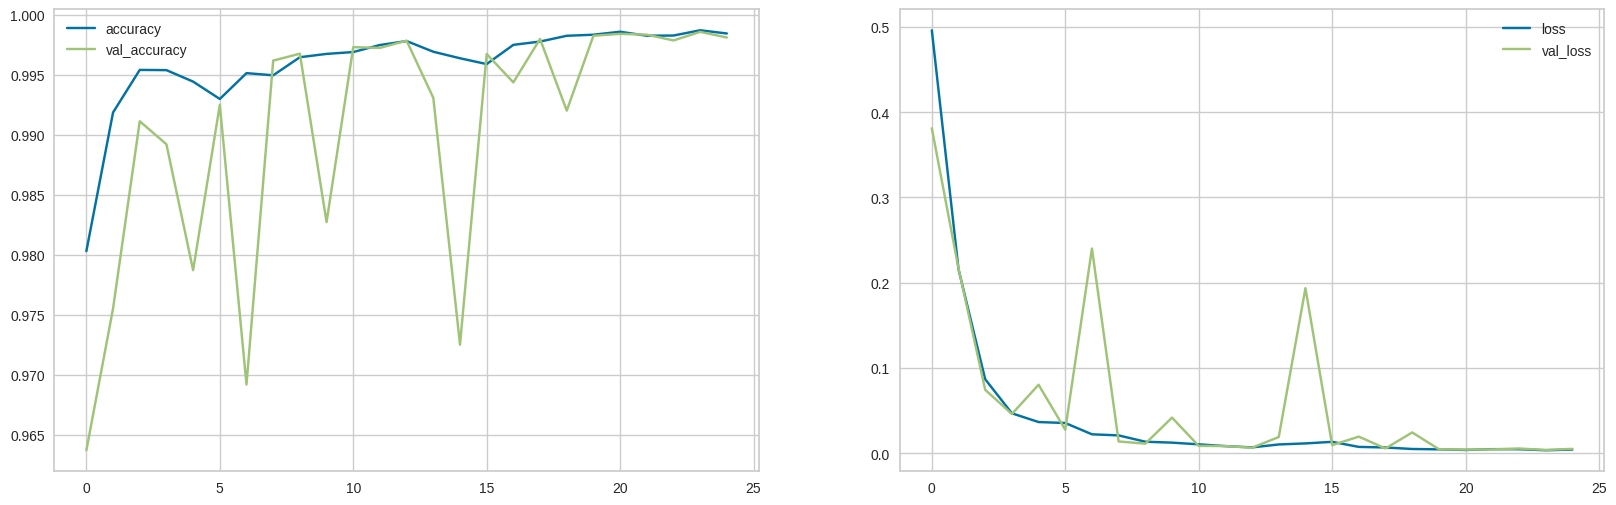

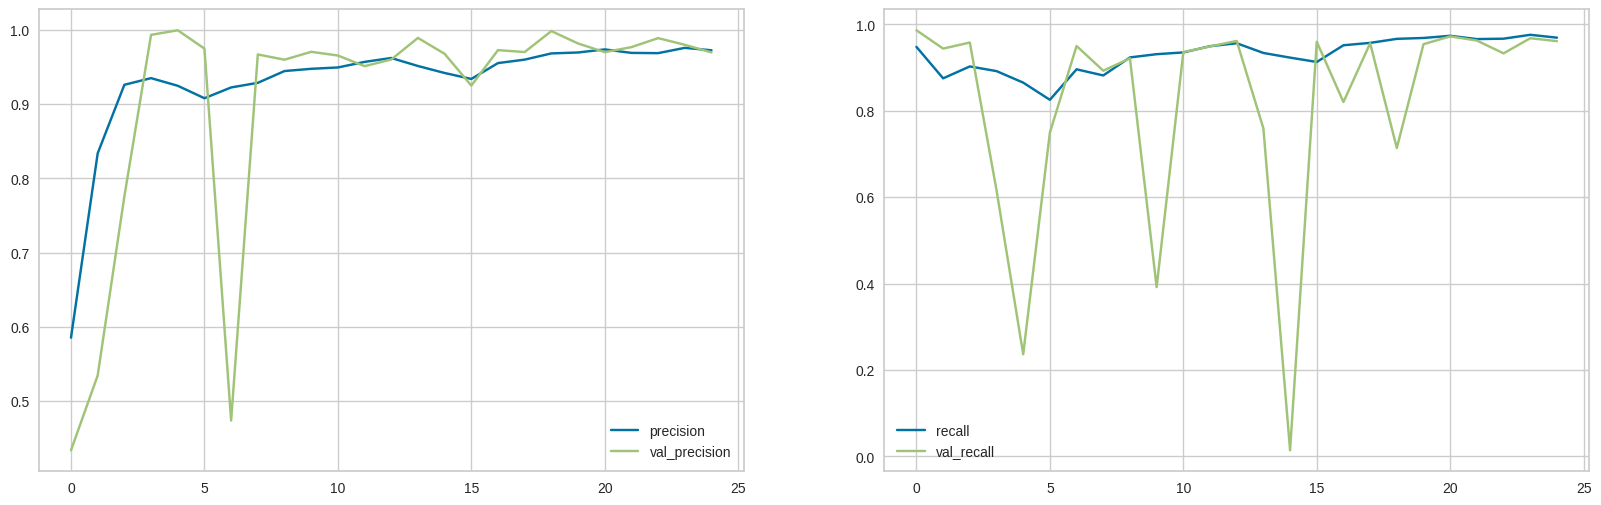

In [ ]:
plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)
plt.plot(results.history['accuracy'], label='accuracy')
plt.plot(results.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(results.history['loss'], label='loss')
plt.plot(results.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)
plt.plot(results.history['precision_1'], label='precision')
plt.plot(results.history['val_precision_1'], label='val_precision')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(results.history['recall_1'], label='recall')
plt.plot(results.history['val_recall_1'], label='val_recall')
plt.legend()
plt.show()

model_name = "segnet-model"
pickle.dump(model, open(model_name, 'wb'))

In [ ]:
model_name = "segnet_model_10K.h5"
model.save(model_name)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
model.evaluate(X_test, Y_test)

63/63 [==============================] - 9s 138ms/step - loss: 0.0049 - accuracy: 0.9981 - precision_1: 0.9639 - recall_1: 0.9634


[0.0048705535009503365,
 0.9980766177177429,
 0.963922917842865,
 0.9633718132972717]

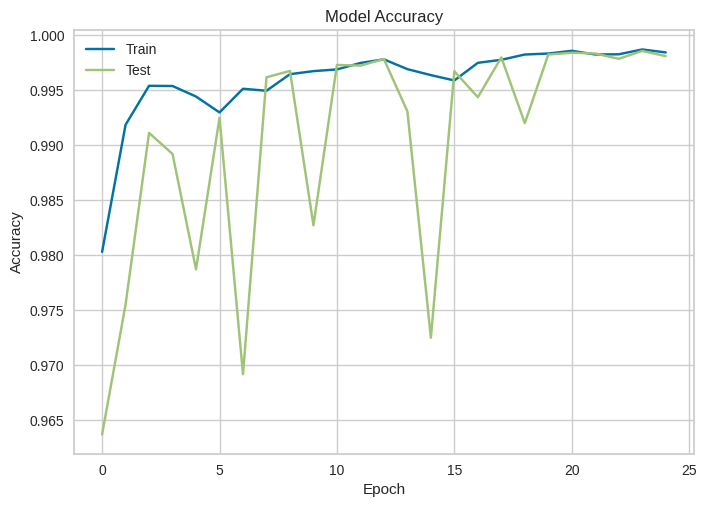

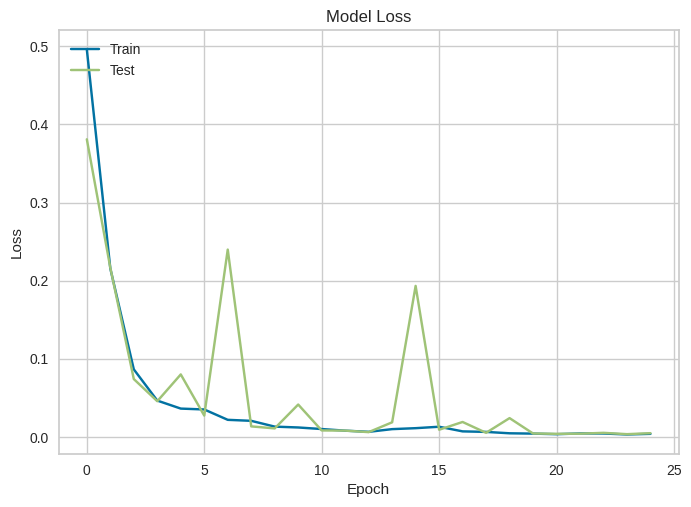

In [ ]:
plt.plot(results.history['accuracy'])
plt.plot(results.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
from matplotlib.gridspec import GridSpec
from random import randint, sample

63/63 [==============================] - 9s 136ms/step


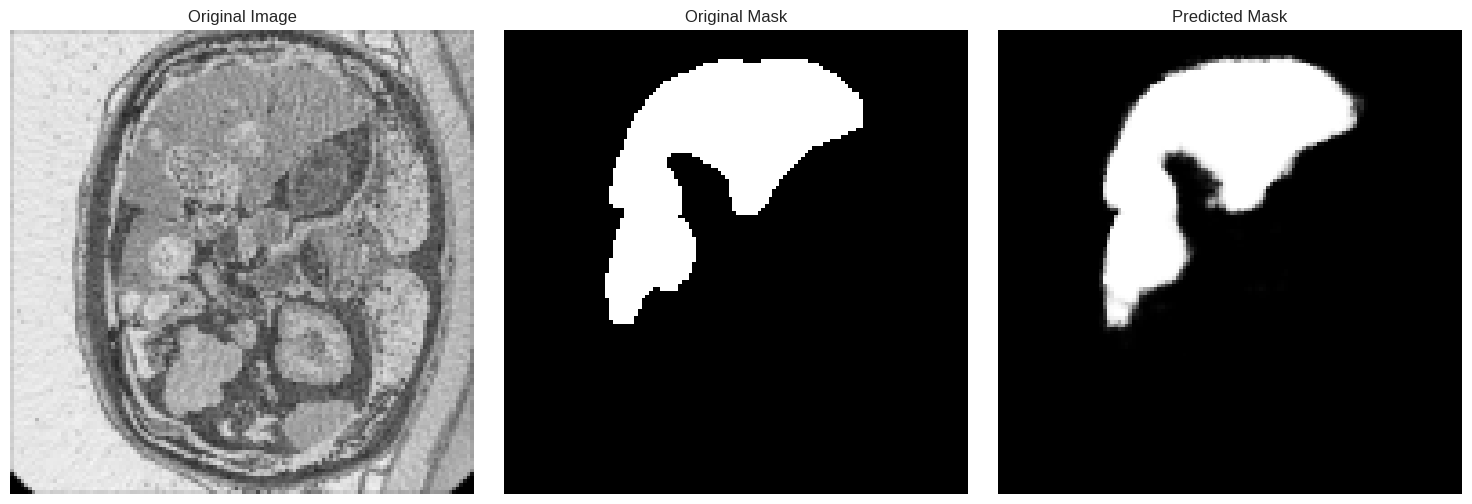

In [ ]:
# Tahminlerin yapılması
pred = model.predict(X_test, verbose=1)

# Rastgele bir indeks seçimi
# ranidx = randint(0, len(Y_test) - 1)
ranidx = 1144

# Küçültülmüş görsellerin boyutları
figsize = (15, 5)
img_size = (3, 3)

# GridSpec tanımı
gs = GridSpec(1, 3)

plt.figure(figsize=figsize)

# Orijinal görüntüyü görselleştirme
plt.subplot(gs[0])
plt.imshow(X_test[ranidx])  # Orijinal görüntü
plt.axis('off')
plt.title("Original Image")

# Orijinal maskeyi görselleştirme
plt.subplot(gs[1])
plt.imshow(Y_test[ranidx][:, :, 0], cmap='gray')  # İlk kanalı görüntüle
plt.axis('off')
plt.title("Original Mask")

# Tahmin edilen maskeyi görselleştirme
plt.subplot(gs[2])
plt.imshow(pred[ranidx][:, :, 0], cmap='gray')  # İlk kanalı görüntüle
plt.axis('off')
plt.title("Predicted Mask")

plt.tight_layout()
plt.show()

In [ ]:
import tensorflow as tf
import numpy as np

def dice_coefficient(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    return (2.0 * intersection + tf.keras.backend.epsilon()) / (union + tf.keras.backend.epsilon())

def jaccard_index(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    return (intersection + tf.keras.backend.epsilon()) / (union + tf.keras.backend.epsilon())

def f1_score(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    precision = tf.reduce_sum(y_true * y_pred) / (tf.reduce_sum(y_pred) + tf.keras.backend.epsilon())
    recall = tf.reduce_sum(y_true * y_pred) / (tf.reduce_sum(y_true) + tf.keras.backend.epsilon())
    return (2.0 * precision * recall) / (precision + recall + tf.keras.backend.epsilon())

# y_true ve y_pred verilerinin hazırlanması
y_pred = model.predict(X_test)
y_pred_thresh = (y_pred > 0.5).astype(np.uint8)  # Eşikleme işlemi (binary classification)

# Y_test ve y_pred_thresh'in şekillerini karşılaştırma
y_true = Y_test.astype(np.uint8)
y_pred = y_pred_thresh

# Dice Coefficient, Jaccard Index ve F1 Score hesaplama
dice = dice_coefficient(y_true, y_pred)
jaccard = jaccard_index(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print("Dice Coefficient:", dice.numpy())
print("Jaccard Index:", jaccard.numpy())
print("F1 Score:", f1.numpy())


63/63 [==============================] - 9s 143ms/step
Dice Coefficient: 0.9636473
Jaccard Index: 0.9298449
F1 Score: 0.96364725
